In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from datetime import datetime, timedelta

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Manipulação de Dados
import numpy as np
import pandas as pd

In [ ]:
# Importação da biblioteca de finanças para coleta de dados
import yfinance as yf

In [ ]:
import tensorflow as tf

In [ ]:
# Função para calcular os próximos 7 dias úteis
def get_next_weekdays(start_date, num_days):
    current_date = start_date
    weekdays = []
    while len(weekdays) < num_days:
        if current_date.weekday() < 5:  # Dias úteis (0=segunda-feira, ..., 4=sexta-feira)
            weekdays.append(current_date)
        current_date += timedelta(days=1)
    return weekdays

In [ ]:
# Caminho do modelo salvo no Google Drive (ajuste conforme necessário)
model_path = '/content/drive/MyDrive/best_lstm_model_v4.keras'

In [ ]:
# Carrega o modelo salvo
model = tf.keras.models.load_model(model_path)

In [ ]:
# Puxa os últimos 31 dias de dados do Yahoo Finance (para garantir uma série consistente)
ticker = 'AAPL'
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=31)).strftime('%Y-%m-%d')

In [ ]:
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Prepara os dados para o modelo
data = data[['Close']].reset_index()
data.rename(columns={'Date': 'date', 'Close': 'value'}, inplace=True)
data['date'] = pd.to_datetime(data['date'])

In [ ]:
# Garante que as datas estão ordenadas
data = data.sort_values('date')

In [ ]:
# Usa os últimos 7 valores de fechamento como entrada para o modelo
last_7_values = data['value'].iloc[-7:].values.reshape(-1, 1)

In [ ]:
# Normaliza os valores de entrada usando a média e o desvio padrão dos últimos 7 dias
mean_value = last_7_values.mean()
std_value = last_7_values.std()
last_7_values_scaled = (last_7_values - mean_value) / std_value

In [ ]:
# Redimensiona os dados normalizados para o formato esperado pelo modelo
last_7_values_scaled = last_7_values_scaled.reshape(1, 7, 1)

In [ ]:
# Previsões para os próximos 7 dias úteis
predictions = []
next_dates = get_next_weekdays(datetime.now(), 7)

In [ ]:
for i in range(7):
    # Faz a previsão
    predicted_value_scaled = model.predict(last_7_values_scaled)[0][0]

    # Reverte a normalização para obter o valor original
    predicted_value = (predicted_value_scaled * std_value) + mean_value
    predictions.append(predicted_value)

    # Atualiza os valores de entrada com o novo valor previsto (reescalonado)
    predicted_value_scaled = (predicted_value - mean_value) / std_value
    last_7_values_scaled = np.concatenate(
        (last_7_values_scaled[:, 1:, :], np.array([[[predicted_value_scaled]]])), axis=1
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [ ]:
# Combina previsões com as datas
results = pd.DataFrame({'date': next_dates, 'predicted_value': predictions})

In [ ]:
# Exibe os resultados
print(results)

                        date  predicted_value
0 2024-11-28 00:06:14.378433       235.415559
1 2024-11-29 00:06:14.378433       235.733466
2 2024-12-02 00:06:14.378433       235.923809
3 2024-12-03 00:06:14.378433       236.033929
4 2024-12-04 00:06:14.378433       236.097577
5 2024-12-05 00:06:14.378433       236.141613
6 2024-12-06 00:06:14.378433       236.173848


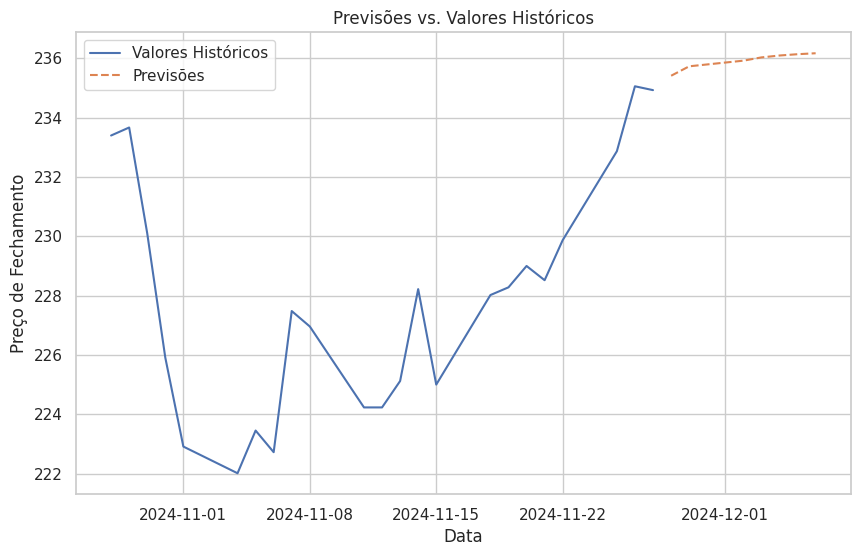

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data['date'], data['value'], label='Valores Históricos')
plt.plot(results['date'], results['predicted_value'], label='Previsões', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.title('Previsões vs. Valores Históricos')
plt.legend()
plt.show()


In [ ]:
# Remove o MultiIndex das colunas
data.columns = data.columns.get_level_values(1)

Index(['', 'AAPL'], dtype='object', name='Ticker')


In [ ]:
# Ajustar os nomes das colunas, removendo colunas vazias
data = data.rename(columns={'': 'date', 'AAPL': 'value'})

# Selecionar apenas as colunas necessárias
historical_data = data[['date', 'value']].copy()

# Adicionar a coluna 'type' para diferenciar
historical_data['type'] = 'Histórico'

# Converte 'date' para manter apenas o dia
historical_data['date'] = pd.to_datetime(historical_data['date']).dt.date

# Remover valores nulos, se houver
historical_data.dropna(inplace=True)

Ticker        date       value       type
0       2024-10-28  233.399994  Histórico
1       2024-10-29  233.669998  Histórico
2       2024-10-30  230.100006  Histórico
3       2024-10-31  225.910004  Histórico
4       2024-11-01  222.910004  Histórico
Ticker        date       value       type
18      2024-11-21  228.520004  Histórico
19      2024-11-22  229.869995  Histórico
20      2024-11-25  232.869995  Histórico
21      2024-11-26  235.059998  Histórico
22      2024-11-27  234.929993  Histórico


In [ ]:
# Ajustar os nomes das colunas para consistência
predicted_data = results.rename(columns={'predicted_value': 'value'})

# Adicionar a coluna 'type' para diferenciar
predicted_data['type'] = 'Previsão'

# Garantir que 'date' tenha apenas o dia
predicted_data['date'] = pd.to_datetime(predicted_data['date']).dt.date

# Remover valores nulos, se houver
predicted_data.dropna(inplace=True)

         date       value      type
0  2024-11-28  235.415559  Previsão
1  2024-11-29  235.733466  Previsão
2  2024-12-02  235.923809  Previsão
3  2024-12-03  236.033929  Previsão
4  2024-12-04  236.097577  Previsão
         date       value      type
2  2024-12-02  235.923809  Previsão
3  2024-12-03  236.033929  Previsão
4  2024-12-04  236.097577  Previsão
5  2024-12-05  236.141613  Previsão
6  2024-12-06  236.173848  Previsão


In [ ]:
# Combinar os DataFrames
combined_data = pd.concat([historical_data, predicted_data], ignore_index=True)

# Garantir que apenas as colunas necessárias estejam no resultado final
combined_data = combined_data[['date', 'value', 'type']]

         date       value       type
0  2024-10-28  233.399994  Histórico
1  2024-10-29  233.669998  Histórico
2  2024-10-30  230.100006  Histórico
3  2024-10-31  225.910004  Histórico
4  2024-11-01  222.910004  Histórico
          date       value       type
16  2024-11-19  228.279999  Histórico
17  2024-11-20  229.000000  Histórico
18  2024-11-21  228.520004  Histórico
19  2024-11-22  229.869995  Histórico
20  2024-11-25  232.869995  Histórico
21  2024-11-26  235.059998  Histórico
22  2024-11-27  234.929993  Histórico
23  2024-11-28  235.415559   Previsão
24  2024-11-29  235.733466   Previsão
25  2024-12-02  235.923809   Previsão
26  2024-12-03  236.033929   Previsão
27  2024-12-04  236.097577   Previsão
28  2024-12-05  236.141613   Previsão
29  2024-12-06  236.173848   Previsão


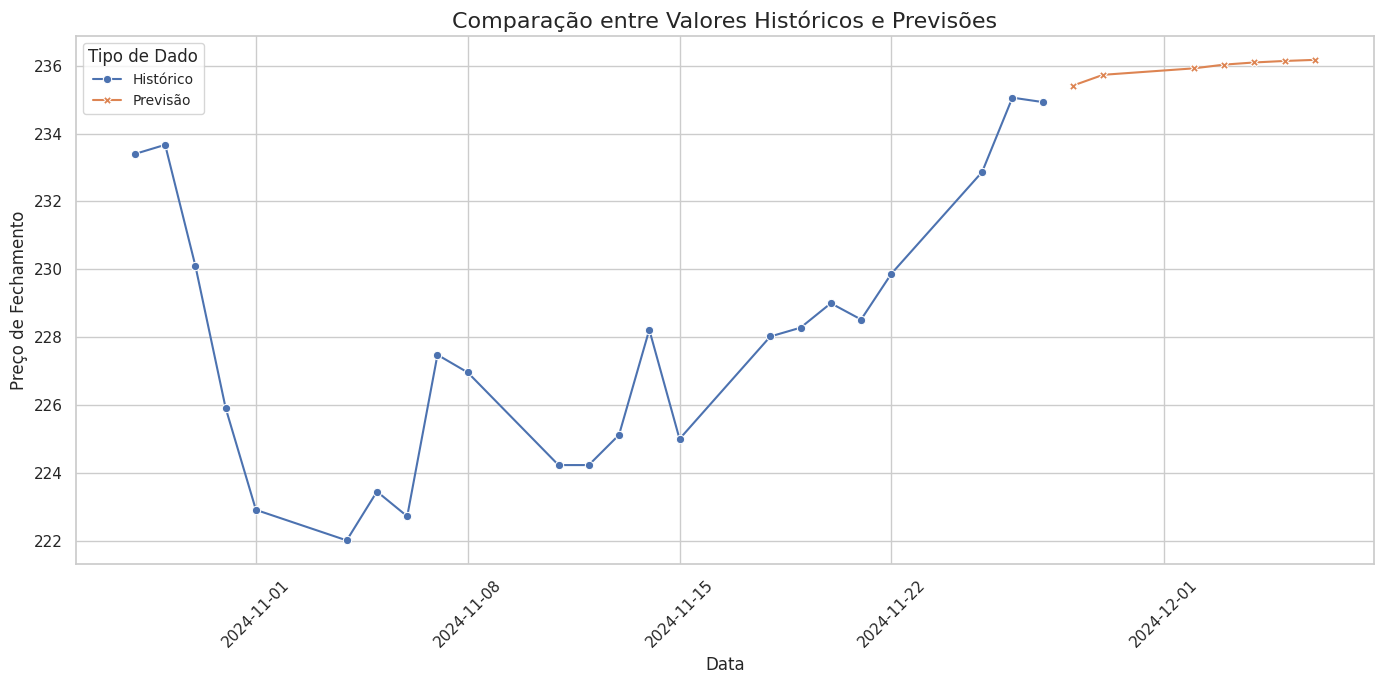

In [ ]:
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=combined_data,
    x='date',
    y='value',
    hue='type',
    style='type',
    markers=True,
    dashes=False
)

plt.title('Comparação entre Valores Históricos e Previsões', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço de Fechamento', fontsize=12)
plt.legend(title='Tipo de Dado', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


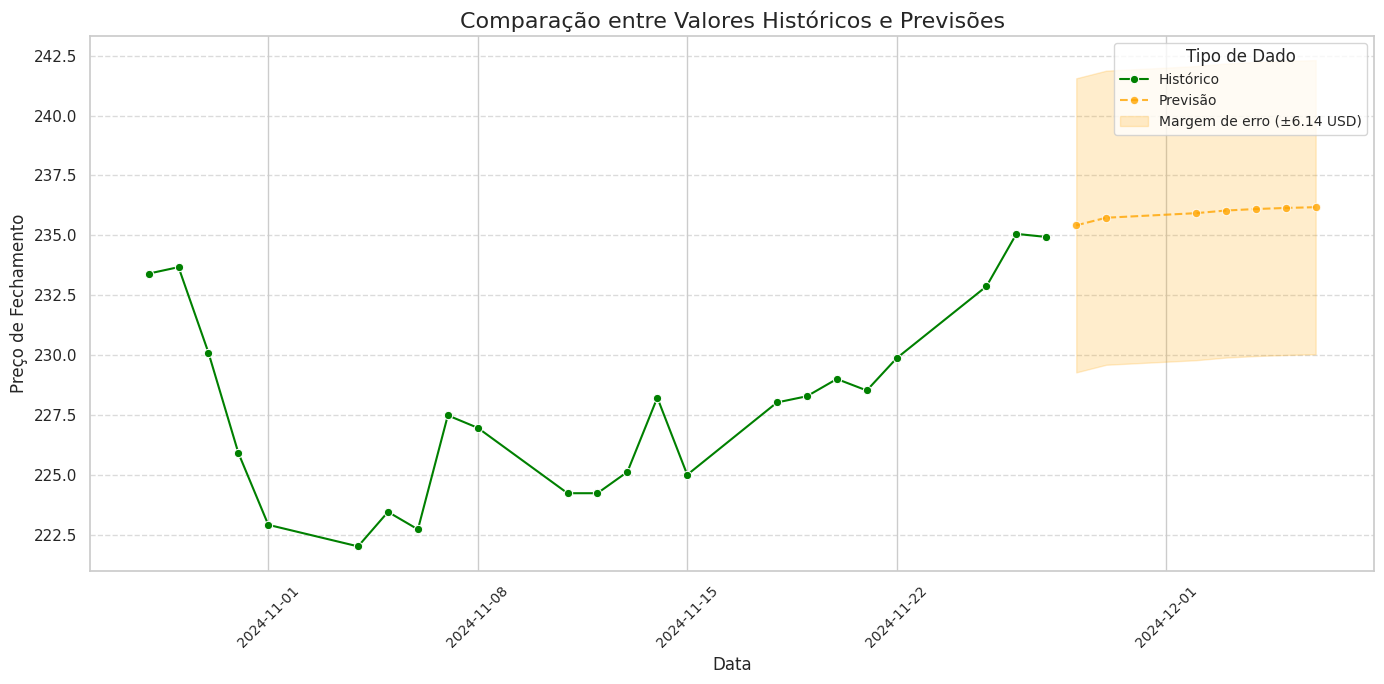

In [ ]:
# Adicionar colunas de intervalo de confiança ao predicted_data
rmse = 6.14
predicted_data['lower_bound'] = predicted_data['value'] - rmse
predicted_data['upper_bound'] = predicted_data['value'] + rmse

# Plotar o gráfico com a margem de erro
plt.figure(figsize=(14, 7))

# Histórico
sns.lineplot(
    data=historical_data,
    x='date',
    y='value',
    label='Histórico',
    color='green',
    markers=True,
    dashes=False,
    marker='o'
)

# Previsões
sns.lineplot(
    data=predicted_data,
    x='date',
    y='value',
    label='Previsão',
    color='orange',
    linestyle='--',
    alpha=0.8,
    markers=True,
    dashes=False,
    marker='o'
)

# Intervalo de confiança
plt.fill_between(
    predicted_data['date'],
    predicted_data['lower_bound'],
    predicted_data['upper_bound'],
    color='orange',
    alpha=0.2,
    label='Margem de erro (±6.14 USD)'
)


# Personalizações
plt.title('Comparação entre Valores Históricos e Previsões', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço de Fechamento', fontsize=12)
plt.legend(title='Tipo de Dado', fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Exibir o gráfico
plt.show()
